# Ocular Disease Recognition - EDA

In [35]:
#%%capture
#!pip install openpyxl

In [36]:
#importing libraries
import tensorflow.keras
import DataGenerator
import Metrics

In [37]:
import joblib
import numpy as np
import pandas as pd 
#pd.set_option('display.max_rows', 5000)
import os
import cv2
from textwrap import wrap
from random import randint
import argparse
import h5py
import matplotlib 
import matplotlib.pyplot as plt
from pickle import dump
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import re


from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Flatten,Bidirectional,Reshape,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, model_from_json, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import scipy as sp
import scipy.misc
import shutil
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io
import sklearn.metrics as skm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import  confusion_matrix,classification_report

In [38]:
# setting up variables for file paths 
ROOT_PATH = '../Dataset/kaggle_ocular_org/'
DATA_PATH = f'{ROOT_PATH}/full_df.csv'
TRAINING_DATA_PATH = f'{ROOT_PATH}/ODIR-5K/ODIR-5K/data.xlsx'
IMG_PRE_PROCESSED_DIR = f'{ROOT_PATH}/preprocessed_images'
IMG_train_DIR = f'{ROOT_PATH}kaggle_ocular/TrainingImages/'
IMG_test_DIR = f'{ROOT_PATH}kaggle_ocular/TestingImages/'

In [39]:
# reading the dataset csv file
df = pd.read_csv(DATA_PATH)
training_df = pd.read_excel(TRAINING_DATA_PATH)
print(df.shape)
print(training_df.shape)

(6392, 19)
(3500, 15)


In [40]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [41]:
training_df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')

In [42]:
training_df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1


In [43]:
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


## Univariate Analysis of Dataset

In [44]:
#Some common functions for plotting the data colunmns
# Function to plot  distribution graph
def plotDist(df, col):
    f, axes = plt.subplots(figsize=(10, 5))    
    sns.histplot(df[col], label=col)     
    axes.set(xlabel=(col))    
    plt.legend();
    
# Function to for  bar plot
def plotBar(df, col):
    f, axes = plt.subplots(figsize=(10, 5))
    plt.barplot(df[col], label=col)                  
    axes.set(xlabel=(col))    
    plt.legend(); 
    
# Function for printing count plot for given dataframe and column
def plotCount(df, col):       
    plt.figure(figsize=(5, 5))
    #sns.set(style="darkgrid")
    ax = sns.countplot(x=col, data=df)
    ax.set_ylabel('number of records')
    ax.set_xlabel('patient sex') 

### Analyis of Data with resepect to Patient's age 

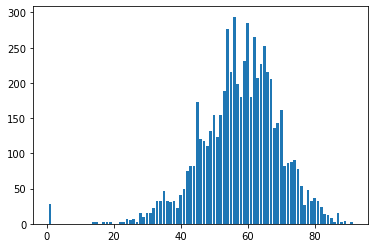

In [45]:
ages = df['Patient Age'].value_counts()
plt.bar(ages.index, ages)
plt.show()

In [46]:
df['Patient Age'].value_counts()

56    294
60    285
54    277
62    265
65    252
     ... 
22      2
14      2
17      2
88      2
91      2
Name: Patient Age, Length: 75, dtype: int64

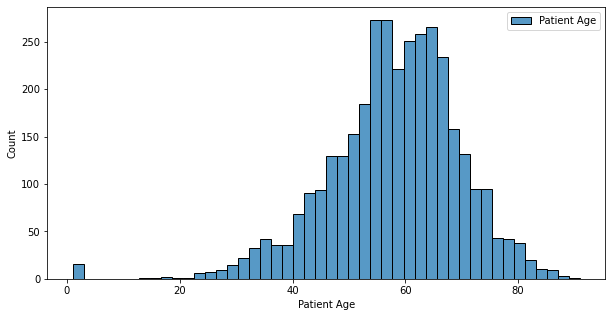

In [47]:
plotDist(training_df, 'Patient Age')

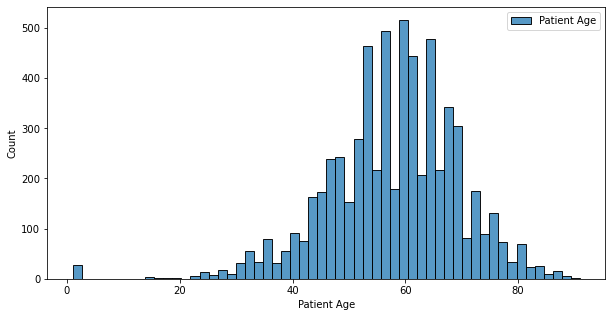

In [48]:
plotDist(df, 'Patient Age')

### Analyis of Data with resepect to Patient's gender

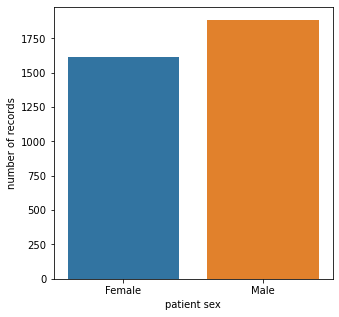

In [49]:
plotCount(training_df, 'Patient Sex')

In [50]:
df['Patient Sex'].value_counts()

Male      3424
Female    2968
Name: Patient Sex, dtype: int64

### Analyis of Data with resepect to disease classes

In [51]:
## removing square brackets from the label column
df['labels'] = df['labels'].apply(lambda l: l[2])
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [52]:
class_counts = df['labels'].value_counts()

In [53]:
class_counts

N    2873
D    1608
O     708
C     293
G     284
A     266
M     232
H     128
Name: labels, dtype: int64

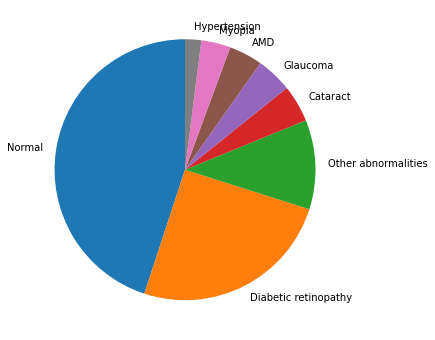

In [54]:
# preparing the pie chart to understand disease class distribution in dataset
plt.figure(figsize=(6, 6))
class_labels = ['Normal', 'Diabetic retinopathy', 'Other abnormalities', 'Cataract', 'Glaucoma', 'AMD','Myopia', 'Hypertension']
plt.pie(class_counts, labels=class_labels, startangle=90)
plt.show()

## Bivariate analysis of Dataset 

In [70]:
# Function to filter and return a dataframe object with rows representing those image instances
# where the given disease is diagnosed
def filter_on_disease(df, disease_identifier):
    filtered_df = df.loc[(df[disease_identifier] == 1)]
    return filtered_df

def get_distribution(df, column, disease):
    col = df[column].value_counts()  

    fig, ax = plt.subplots(figsize=(5,5))
    fig.suptitle(f'prevalence of {disease} against {column} distribution ')
    ax.set_ylabel(f'number of records for {disease} ')
    ax.set_xlabel(column) 
    ax.bar(col.index, col)
    
 # plotting correlations on a heatmap    
def plotHeatMap(df):
    # figure size
    plt.figure(figsize=(10,8))

    # heatmap
    g=sns.heatmap(df, cmap="YlGnBu", annot=True, fmt='g')

    # increasing y limit to get full square shape for first and last rows  of map
    top,bottom = g.get_ylim()

    g.set_ylim(top+0.5, bottom-0.5)
    plt.show()
    
     

    

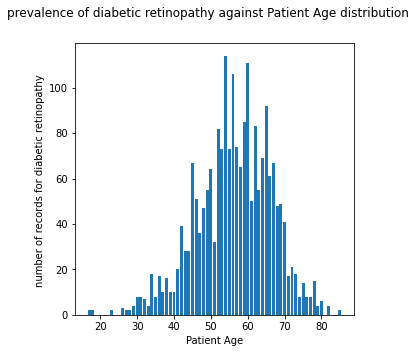

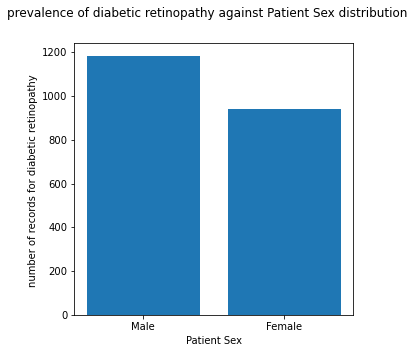

In [56]:
get_distribution(filter_on_disease(df, 'D'), 'Patient Age', 'diabetic retinopathy')
get_distribution(filter_on_disease(df, 'D'), 'Patient Sex', 'diabetic retinopathy')

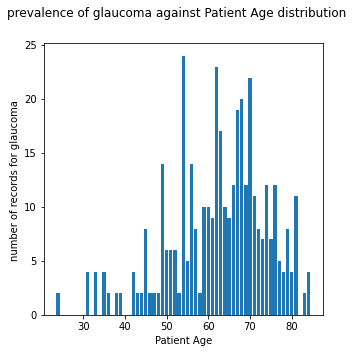

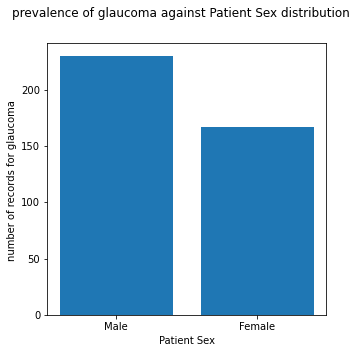

In [57]:
get_distribution(filter_on_disease(df, 'G'), 'Patient Age', 'glaucoma')
get_distribution(filter_on_disease(df, 'G'), 'Patient Sex', 'glaucoma')

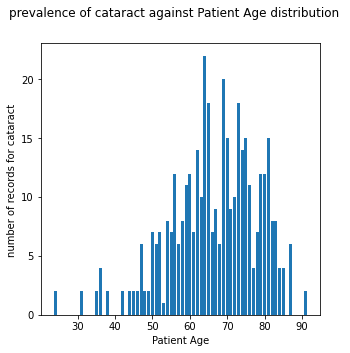

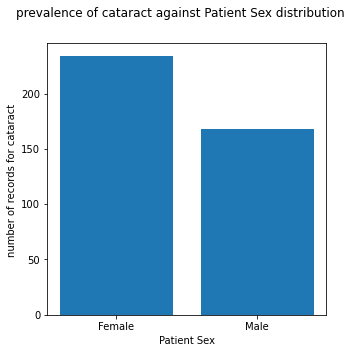

In [58]:
get_distribution(filter_on_disease(df, 'C'), 'Patient Age', 'cataract')
get_distribution(filter_on_disease(df, 'C'), 'Patient Sex', 'cataract')

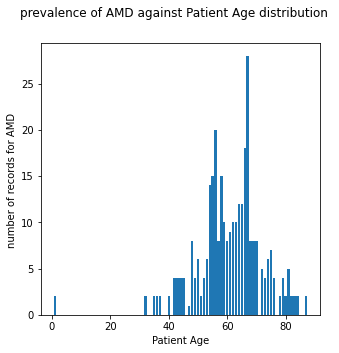

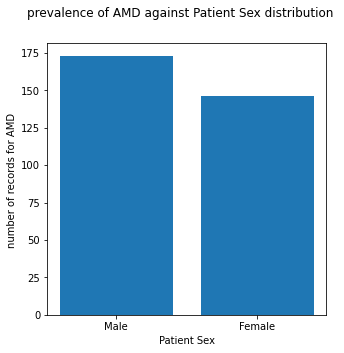

In [59]:
get_distribution(filter_on_disease(df, 'A'), 'Patient Age', 'AMD')
get_distribution(filter_on_disease(df, 'A'), 'Patient Sex', 'AMD')

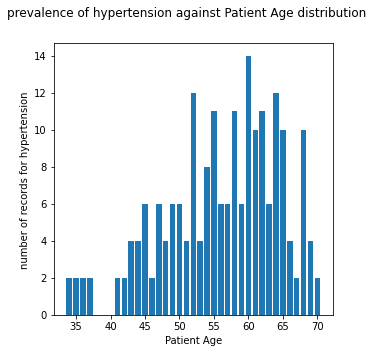

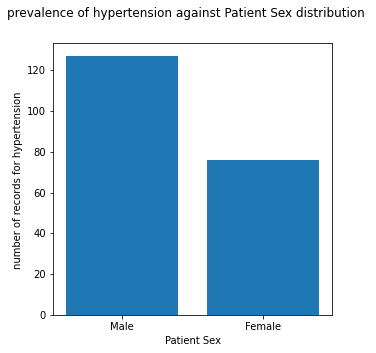

In [60]:
get_distribution(filter_on_disease(df, 'H'), 'Patient Age', 'hypertension')
get_distribution(filter_on_disease(df, 'H'), 'Patient Sex', 'hypertension')

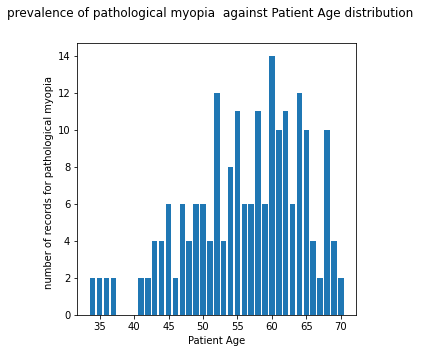

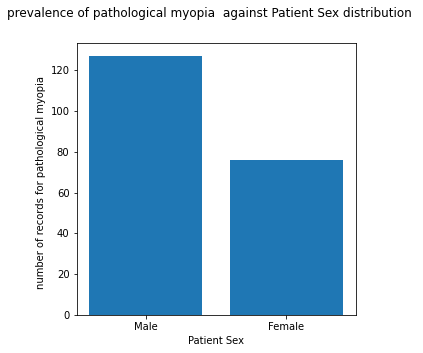

In [61]:
get_distribution(filter_on_disease(df, 'H'), 'Patient Age', 'pathological myopia ')
get_distribution(filter_on_disease(df, 'H'), 'Patient Sex', 'pathological myopia ')


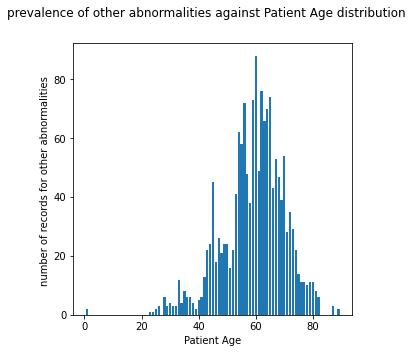

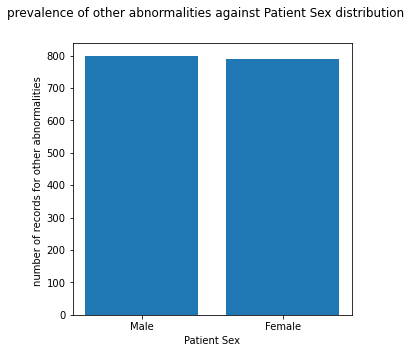

In [62]:
get_distribution(filter_on_disease(df, 'O'), 'Patient Age', 'other abnormalities')
get_distribution(filter_on_disease(df, 'O'), 'Patient Sex', 'other abnormalities')

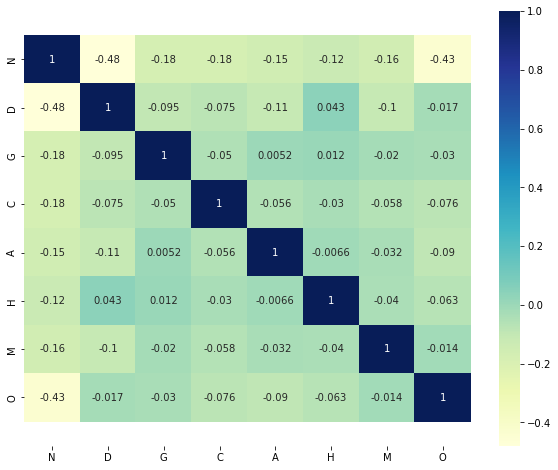

In [63]:
cols=['N','D','G','C','A','H','M','O']
cor = training_df[cols].corr()
plotHeatMap(cor)

In [71]:
co = training_df[['N', 'D', 'G', 'C','A','H','M','O']]
correlation = co.T.dot(co)
correlation

,N,D,G,C,A,H,M,O
N,1140,0,0,0,0,0,0,0
D,0,1128,32,39,16,45,19,303
G,0,32,215,3,11,8,7,49
C,0,39,3,212,0,2,0,31
A,0,16,11,0,164,4,3,16
H,0,45,8,2,4,103,0,12
M,0,19,7,0,3,0,174,44
O,0,303,49,31,16,12,44,979


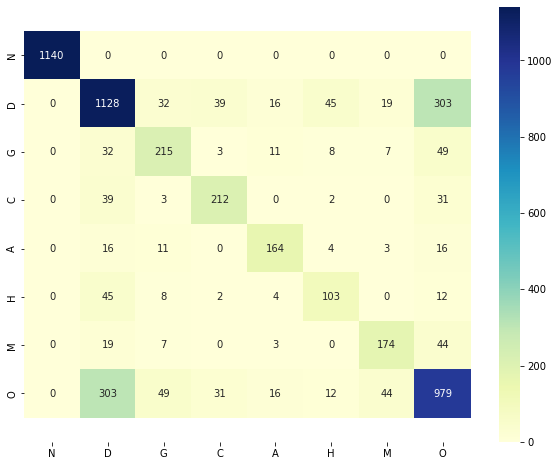

In [72]:
plotHeatMap(correlation)

In [34]:
totals = co.sum()
correlation_2 = correlation / totals 
correlation_2.style.background_gradient().set_precision(2)

,N,D,G,C,A,H,M,O
N,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
D,0.00,1.00,0.15,0.18,0.10,0.44,0.11,0.31
G,0.00,0.03,1.00,0.01,0.07,0.08,0.04,0.05
C,0.00,0.03,0.01,1.00,0.00,0.02,0.00,0.03
A,0.00,0.01,0.05,0.00,1.00,0.04,0.02,0.02
H,0.00,0.04,0.04,0.01,0.02,1.00,0.00,0.01
M,0.00,0.02,0.03,0.00,0.02,0.00,1.00,0.04
O,0.00,0.27,0.23,0.15,0.10,0.12,0.25,1.00


In [ ]:
training_df = training_df.set_index('ID')
#training_df['dlabel'] = training_df.apply(lambda x: getOneHotVector(x), axis=1)
training_df['label'] = training_df.apply(lambda x: multilabel(x), axis=1)
training_df.head(5)
